In [3]:
import mido
from mido import MidiFile, MidiTrack, Message
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import numpy as np

In [1]:
!pip install keras==2.1.1

    100% |████████████████████████████████| 307kB 7.0MB/s ta 0:00:011
keras-preprocessing 1.0.2 has requirement keras>=2.1.6, but you'll have keras 2.1.1 which is incompatible.
keras-applications 1.0.4 has requirement keras>=2.1.6, but you'll have keras 2.1.1 which is incompatible.
  Found existing installation: Keras 2.2.1
    Uninstalling Keras-2.2.1:
      Successfully uninstalled Keras-2.2.1
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pkg_resources
pkg_resources.require('keras==2.1.1')
import keras

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
import os
os.listdir(os.getcwd()+'/midi_songs')

['Ff7-Jenova_Absolute.mid',
 'FF8_Shuffle_or_boogie_pc.mid',
 'ahead_on_our_way_piano.mid',
 'balamb.mid',
 'DOS.mid',
 'FF3_Battle_(Piano).mid',
 'Suteki_Da_Ne_(Piano_Version).mid',
 'caitsith.mid',
 'sera_.mid',
 'Oppressed.mid',
 'ff4-airship.mid',
 'ff7themep.mid',
 'FFVII_BATTLE.mid',
 'electric_de_chocobo.mid',
 'Ff7-One_Winged.mid',
 'Finalfantasy5gilgameshp.mid',
 'Cids.mid',
 'lurk_in_dark.mid',
 'FFX_-_Ending_Theme_(Piano_Version)_-_by_Angel_FF.mid',
 'ff4pclov.mid',
 'AT.mid',
 'Final_Fantasy_7_-_Judgement_Day_Piano.mid',
 '8.mid',
 'sobf.mid',
 'In_Zanarkand.mid',
 'waltz_de_choco.mid',
 'z_aeristhemepiano.mid',
 'Final_Fantasy_Matouyas_Cave_Piano.mid',
 'redwings.mid',
 'roseofmay-piano.mid',
 'ff4_piano_collections-main_theme.mid',
 'dontbeafraid.mid',
 'dayafter.mid',
 'FF6epitaph_piano.mid',
 'FFIX_Piano.mid',
 'FFIII_Edgar_And_Sabin_Piano.mid',
 'ultros.mid',
 '0fithos.mid',
 'BlueStone_LastDungeon.mid',
 'ff8-lfp.mid',
 'rufus.mid',
 'ff4-fight1.mid',
 'Life_Stream.mi

In [6]:
mid = MidiFile('midi_songs/'+'Nintendo_-_Pokemon_Fire_Red_Route_1_Piano_Cover_Hard_Version.mid') 
notes = []
velocities = []

In [7]:
for msg in mid:
    if not msg.is_meta:
        if msg.channel == 0:
            if msg.type == 'note_on':
                data = msg.bytes()
                # append note and velocity from [type, note, velocity]
                note = data[1]
                velocity = data[2]
                notes.append(note)
                velocities.append(velocity)
combine = [[i,j] for i,j in zip(notes, velocities) ]

In [8]:
note_min = np.min(notes)
note_max = np.max(notes)
velocities_min = np.min(velocities)
velocities_max = np.max(velocities)

for note in combine:
    note[0] = 2*(note[0]-((note_min+note_max)/2))/(note_max-note_min)

In [9]:
X = []
Y = []
n_prev = 30
for i in range(len(combine)-n_prev):
    x = combine[i:i+n_prev]
    y = combine[i+n_prev]
    X.append(x)
    Y.append(y)
# save a seed to do prediction later
seed = combine[0:n_prev]

In [10]:
model = Sequential()
model.add(LSTM(256, input_shape=(n_prev, 2), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(128, input_shape=(n_prev, 2), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(64, input_shape=(n_prev, 2), return_sequences=False))
model.add(Dropout(0.6))
model.add(Dense(2))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mse', optimizer=optimizer)
filepath="weights/weights-improvement-2-{loss:.4f}-bigger.hdf5"  
model_save_callback = ModelCheckpoint(filepath, monitor='val_acc', 
                                      verbose=1, save_best_only=False, 
                                      mode='auto', period=5)

In [11]:
model.fit(np.array(X), np.array(Y), 32, 5, verbose=1) #callbacks=[model_save_callback])

Epoch 1/5
13070/13070 [==============================] - 38s 3ms/step - loss: 1080.2166
Epoch 2/5
13070/13070 [==============================] - 36s 3ms/step - loss: 354.3590
Epoch 3/5
13070/13070 [==============================] - 35s 3ms/step - loss: 115.8362
Epoch 4/5
13070/13070 [==============================] - 34s 3ms/step - loss: 59.9017
Epoch 5/5
13070/13070 [==============================] - 34s 3ms/step - loss: 50.9801


In [12]:
prediction = []
x = np.expand_dims(seed, axis=0)

for i in range(300):
    preds = model.predict(x)
    x = np.squeeze(x)
    x = np.concatenate((x, preds))
    x = x[1:]
    x = np.expand_dims(x, axis=0)
    preds = np.squeeze(preds)
    prediction.append(preds)

In [13]:
for pred in prediction:
# Undo the preprocessing
    pred[0] = int((pred[0]/2)*(note_max-note_min) + (note_min+note_max)/2)
    pred[1] = int((pred[1]/2)*(velocities_max-velocities_min) + (velocities_min+velocities_max)/2)
    if pred[0] < 24:
        pred[0] = 24
    elif pred[0] > 102:
        pred[0] = 102
    if pred[1] < 0:
        pred[1] = 0
    elif pred[1] > 127:
        pred[1] = 127

In [14]:
mid = MidiFile()
track = MidiTrack()

t = 0
for note in prediction:
    # 147 means note_on
    note = np.asarray([147, note[0], note[1]])
    bytes = note.astype(int)
    msg = Message.from_bytes(bytes[0:3])
    t += 1
    msg.time = t
    track.append(msg)

mid.tracks.append(track)
mid.save('Generated_song_epoch=5.mid')

In [73]:
import matplotlib.pyplot as plt


FUNDS = 85000
TOTAL = 500000

# fig, ax = plt.subplots(111)
# ax.bar([0],[TOTAL], color='grey')
# ax.bar([0],[FUNDS], color='red')

# ax.show()

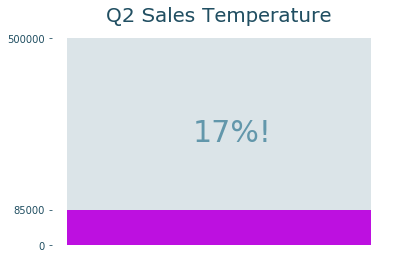

In [74]:
fig, ax = plt.subplots()

hfont = {'fontname':'Helvetica'}

ax.bar([0],[TOTAL], color='#DBE4E8')
ax.bar([0],[FUNDS], color='#BD10E0')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Q2 Sales Temperature', color='#214F62', fontname='Verdana',fontsize=20)
plt.text(-0.07, TOTAL/2, str(round(100*FUNDS/TOTAL))+'%!', fontsize=30, color='#6297AB')

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([0,FUNDS,TOTAL])
ax.tick_params(axis='y', colors='#214F62')